# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="https://github.com/nathanbangwa243/udpj-landmark-classification/blob/main/static_images/icons/noun-advance-2109145.png?raw=1" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

### TRAINING PLATFORM

In [1]:
import shutil
import os

TRAINING_PLATFORM = "KAGGLE" # replace by UDACITY

In [14]:
if TRAINING_PLATFORM == "GOOGLE":
    from google.colab import drive
    drive.mount('/content/drive/')

    os.chdir("/content/drive/MyDrive/learning/udacity/ml-fundamentals/udpj-landmark-classification")

### KAGGLE SETUP

Remember to turn ON internet for download purpose : `Settings Tab > Turn ON internet`

In [15]:
if TRAINING_PLATFORM == "KAGGLE":

    # Répertoires source et destination
    source_dir = '/kaggle/input/udpj-starter-code/udpj-landmark-classification/'
    destination_dir = '/kaggle/working/'

    # Copier tous les fichiers et dossiers de la source vers la destination
    shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

### COMMON SETUP

In [16]:
!pwd
!ls

/kaggle/working
README.md		 mean_and_std.pt	   static_images
app.ipynb		 requirements.txt	   transfer_learning.ipynb
cnn_from_scratch.ipynb	 reverse_requirements.txt
install_requirements.sh  src


In [17]:
!apt install build-essential

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.8ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 80 not upgraded.


In [18]:
!cat requirements.txt

opencv-python-headless==4.5.3.56
matplotlib==3.4.3
numpy==1.21.2
pillow==7.0.0
bokeh==2.1.1
torch==1.9.0
torchvision==0.10.0
tqdm==4.63.0
ipywidgets==7.6.5
livelossplot==0.5.4
pytest==7.1.1
pandas==1.3.5
seaborn==0.11.2


In [19]:
!pip install --upgrade pip setuptools wheel


In [20]:
!pip cache purge

Files removed: 12


In [21]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 61.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'error'
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [851 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.6" and sys_platform == "linux" and platform_machine == "aarch64"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.6" and sys_platform == "darwin" and platform_machine == "arm64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_machine != "aarch64" and platform_machine != "arm64"' don't match your environment


In [22]:
# Invert requirements to avoid opencv-python-headless error cancelling other installations
!tac requirements.txt > reverse_requirements.txt

In [23]:
# Install requirements
!pip install -r reverse_requirements.txt | grep -v "already satisfied"

ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.10.0 (from versions: 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0)
ERROR: No matching distribution found for torchvision==0.10.0


In [24]:
!pip install livelossplot==0.5.4

In [25]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
done
Reusing cached mean and std


---
## <img src="https://github.com/nathanbangwa243/udpj-landmark-classification/blob/main/static_images/icons/noun-advance-2109145.png?raw=1" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [26]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.10.13, pytest-8.2.2, pluggy-1.5.0 -- /opt/conda/bin/python3.10
cachedir: .pytest_cache
rootdir: /kaggle/working
plugins: anyio-4.2.0, typeguard-4.1.5
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

=============================== warnings summary ===============================
src/transfer.py::test_get_model_transfer_learning
  /opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
    warnings.warn(

src/transfer.py::test_get_model_transfer_learning
  /opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 

---
## <img src="https://github.com/nathanbangwa243/udpj-landmark-classification/blob/main/static_images/icons/noun-advance-2109145.png?raw=1" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [27]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting

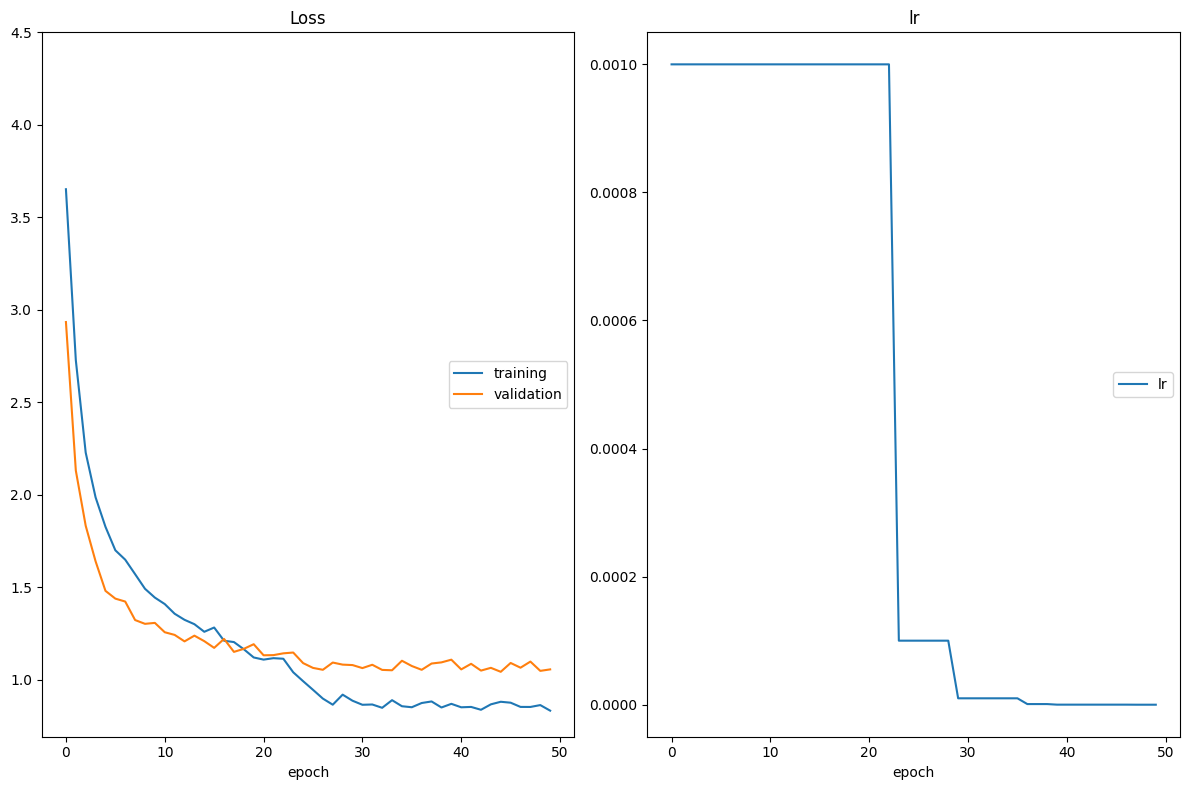

In [28]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
# YOUR CODE HERE
model_transfer = get_model_transfer_learning(model_name="resnet18", n_classes=num_classes)


# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

<img src="https://github.com/nathanbangwa243/udpj-landmark-classification/blob/main/static_images/icons/noun-question-mark-869751.png?raw=1" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<img src="https://github.com/nathanbangwa243/udpj-landmark-classification/blob/main/static_images/icons/noun-answer-3361020.png?raw=1" alt=">" style="width:25px"/>  __Answer:__ 

I chose ResNet18 as the base model for my architecture because it offers a good balance between performance and model size, performing well on ImageNet, which is similar in nature to the landmark classification task. ResNet18's architecture includes residual connections that help mitigate the vanishing gradient problem and allows deeper networks to be trained effectively.

Since ResNet18 was pre-trained on ImageNet, it already has learned rich feature representations for natural scenes. This makes it particularly suitable for landmark classification, which also involves analyzing images of natural scenes.

To adapt ResNet18 for the landmark classification task, I froze its pre-trained layers to use it as a feature extractor and replaced the final classification layer. The new classification head includes a sequence of fully connected layers with dropout for regularization. This configuration is designed to fine-tune the model for the specific number of landmark classes while leveraging the pre-trained features effectively.

This approach ensures that the model benefits from the robust feature extraction capabilities of ResNet18 while being customized to classify landmarks with the appropriate number of output classes.

Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

---
## <img src="https://github.com/nathanbangwa243/udpj-landmark-classification/blob/main/static_images/icons/noun-advance-2109145.png?raw=1" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [29]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  4.41it/s]


Test Loss: 0.961142


Test Accuracy: 73% (918/1250)


0.9611424028873443

# 😊 Look how beautiful it is

---
## <img src="https://github.com/nathanbangwa243/udpj-landmark-classification/blob/main/static_images/icons/noun-advance-2109145.png?raw=1" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [30]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


  0%|                                          | 2/1250 [00:00<04:24,  4.71it/s]code/__torch__/torchvision/transforms/functional.py:188: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
code/__torch__/torchvision/transforms/functional.py:188: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consisten

Accuracy: 0.7512


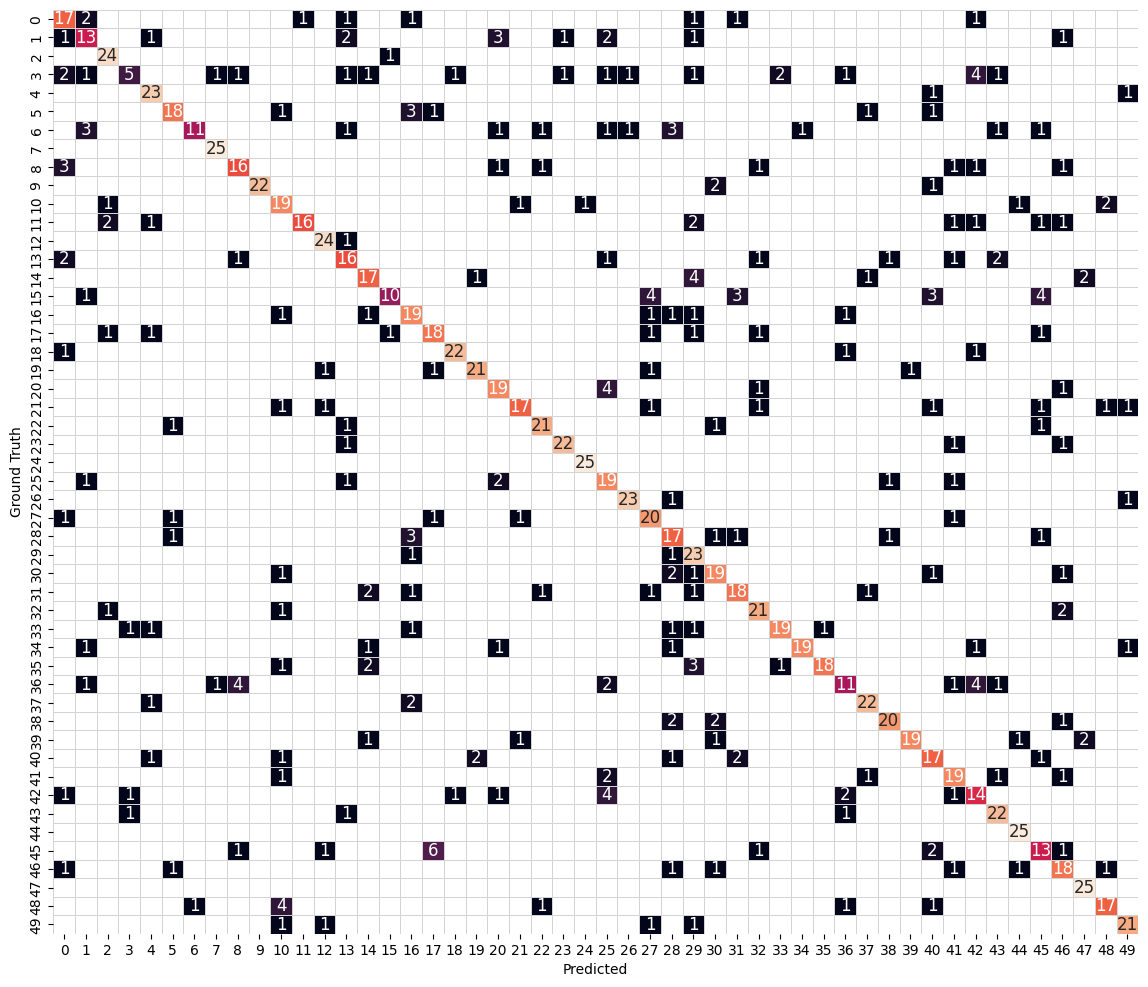

In [31]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)

In [2]:
!ls

README.md               install_requirements.sh  reverse_requirements.txt
app.ipynb               landmark_images/         src/
checkpoints/            mean_and_std.pt          static_images/
cnn_from_scratch.ipynb  requirements.txt         transfer_learning.ipynb


In [3]:
!ls checkpoints/

model_transfer.pt  transfer_exported.pt


In [21]:
import shutil
if TRAINING_PLATFORM == "KAGGLE":
    import kaggle

    # Chemin du dossier à archiver
    source_dir = '/kaggle/working/checkpoints'
    zip_file = '/kaggle/working/dataset.zip'

    # Créer l'archive ZIP
    shutil.make_archive('/kaggle/working/dataset', 'zip', source_dir)
    print(f"Le fichier dataset.zip a été créé à l'emplacement '/kaggle/working/''.")

Le fichier dataset.zip a été créé à l'emplacement '/kaggle/working/''.


In [22]:
!ls

README.md               dataset.zip              reverse_requirements.txt
app.ipynb               install_requirements.sh  src/
checkpoints/            landmark_images/         static_images/
cnn_from_scratch.ipynb  mean_and_std.pt          transfer_learning.ipynb
dataset-metadata.json   requirements.txt
